# Mosaic analysis during slew

Edit here only trigid, trigger_time and your user_name

In [130]:
trigid = '647252296_c0'
triggertime = '2021-07-06T08:17:49.000'
user_name = 'samueleronchini'

In [ ]:
root = f'/home/idies/workspace/Storage/{user_name}/persistent'

# create data directory and work dir if it does not exist
import os
data_dir = f'{root}/{trigid}/data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

workdir = f'{root}/{trigid}'
if not os.path.exists(workdir):
    os.makedirs(workdir)
    
def filter_data(obsid):
    command = f'python -m nitrates.data_prep.mkdb --work_dir {root}/{trigid} '
    ! echo {command}
    ! {command}
    
    command = '' \
    '' \
    'python -m nitrates.data_prep.do_data_setup ' \
    f'--work_dir {root}/{trigid}' \
    f' --trig_time {triggertime}' \
    f' --evfname {root}/data/{obsid}/bat/event/sw{obsid}bevshsl_uf.evt.gz' \
    f' {root}/data/{obsid}/bat/event/sw{obsid}bevshpo_uf.evt.gz' \
    f' --dmask {root}/data/{obsid}/bat/hk/sw{obsid}bdecb.hk.gz' \
    f' --att_fname {root}/data/{obsid}/auxil/sw{obsid}pat.fits.gz' \
    f' --acs_fname {root}/data/{obsid}/auxil/sw{obsid}pat.fits.gz' \
    f' --data_dbfname {root}/{trigid}/results.db'
    
    ! echo {command}
    ! {command}

We first get data from GUANO, using swifttools. For a completed guide to use GUANO API, see https://www.swift.psu.edu/too_api/index.php?md=Swift%20GUANO%20Example%20Notebook.ipynb

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import os
import batanalysis as ba

import logging
import time
from pathlib import Path
import traceback
from swifttools.swift_too import GUANO, Clock, Data

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

import warnings
warnings.filterwarnings("ignore")



def guano_query(triggertime, ext_obsid, workdir, datadir):

    if '.' not in triggertime.split('T')[1]:
        triggertime = triggertime + '.000Z'
    else:
        triggertime = triggertime + 'Z'

    logging.info(f'Using triggertime: {triggertime}')

    guano = GUANO(triggertime=triggertime, successful = False)

    logging.info(guano)

    for item in guano: # this loop is required if multiple triggers are associated with the same obsid
        logging.info(f'running {item}')

        if item.data.exposure is None:
            logging.error(f'No exposure time found for obsid {item.obsid}. Skipping this obsid.')
            exit()

        if ext_obsid is not None:
            obsid = ext_obsid
        else:
            obsid = item.obsid

        start_time_try = time.time()
        event = None
        while time.time() - start_time_try < 1800 and event is None:
            try:
                '''
                We need to remove any data or results already existing, since BatAnalysis can have problems
                '''
                # Remove directories if they exist
                obsid_dir = f"{datadir}/{obsid}"
                obsid_eventresult_dir = f"{datadir}/{obsid}_eventresult"
                if os.path.exists(obsid_dir):
                    os.system(f"rm -rf {obsid_dir}")
                if os.path.exists(obsid_eventresult_dir):
                    os.system(f"rm -rf {obsid_eventresult_dir}")


                data = Data(obsid=obsid, bat=True, outdir=datadir, clobber=True, uksdc=True)
                logging.info(data)
                ba.datadir(datadir)
                event = ba.BatEvent(obsid, is_guano=True)

                # filter data using nitrates
                filter_data(obsid)
                
                # We use here the filtered files produced by NITRATES
                event.detector_quality_file = Path(f'{workdir}/detmask.fits')
                event.event_files = Path(f'{workdir}/filter_evdata.fits')
                event.attitude_file = Path(f'{workdir}/attitude.fits')

                event._parse_event_file()

                ba.mosaic._pcodethresh = 0.01  

            except Exception:
                logging.error(f"Failed to create Data and BatEvent for obsid {obsid}: {traceback.format_exc()}")
    
    return event


In [ ]:
event = guano_query(triggertime, None, workdir, f'{root}/data')

Convert the t0 from UTC to MET

In [131]:
t0 = Clock(utctime=triggertime+'Z').met

## Visualising the attitude info

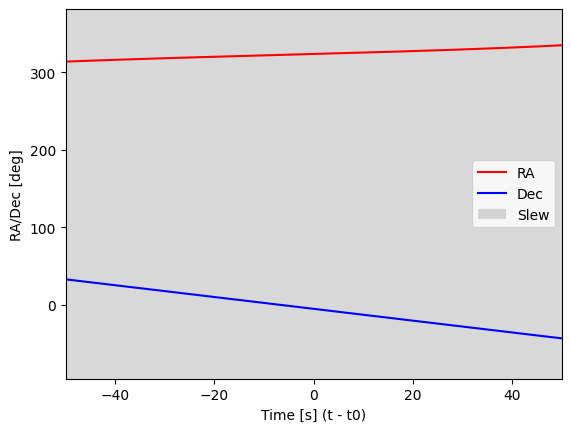

In [132]:
plt.plot(event.attitude.time.value-t0, event.attitude.ra, label='RA', color='red')
plt.plot(event.attitude.time.value-t0, event.attitude.dec, label='Dec', color='blue')

# Identify intervals where RA and Dec change
ra_diff = np.diff(event.attitude.ra.value)
dec_diff = np.diff(event.attitude.dec.value)
margin = 1 / 60  # Margin of 1/60 degree, i.e., 1 arcmin
change_indices = np.where((np.abs(ra_diff) > margin) | (np.abs(dec_diff) > margin))[0]

for idx in change_indices:
    plt.axvspan(event.attitude.time[idx].value - t0, event.attitude.time[idx + 1].value - t0, color='gray', alpha=0.3, linewidth=0, label='Slew' if idx == change_indices[0] else None)

plt.xlim(-50, 50)
plt.xlabel("Time [s] (t - t0)")
plt.ylabel("RA/Dec [deg]")
plt.legend()
plt.show()
plt.savefig(f'{workdir}/attitude.png', dpi=500)
plt.close()

## Check the external position with respect to BAT FOV

In [91]:
output_file = os.path.join(workdir, 'ext_loc_fermi.fit')
! curl -o {output_file} https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/triggers/2021/bn210706346/quicklook/glg_healpix_all_bn210706346.fit

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1549k  100 1549k    0     0   435k      0  0:00:03  0:00:03 --:--:--  435k


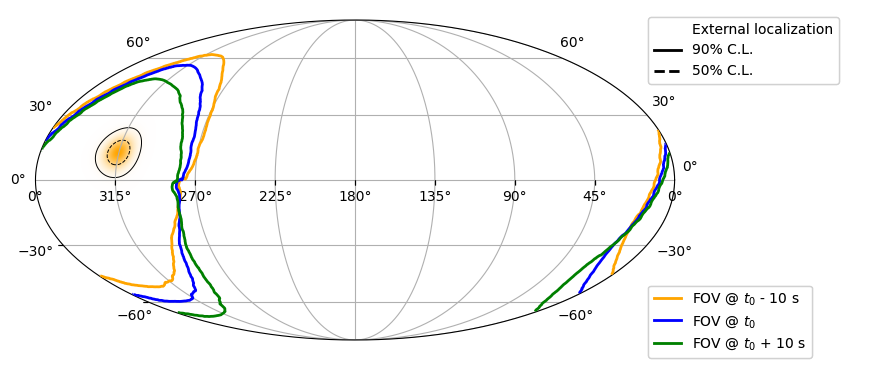

In [92]:
from matplotlib.lines import Line2D
import ligo.skymap.io
import ligo.skymap.plot
import ligo.skymap.postprocess

from matplotlib.colors import LinearSegmentedColormap

def map_ext(fit_file, workdir, ax_globe):

    skymap, _ = ligo.skymap.io.fits.read_sky_map(os.path.join(workdir, fit_file), nest=True, distances=False)
    skymap_prob = skymap.copy()

    white_to_blue = LinearSegmentedColormap.from_list("whiteblue", ["white", "orange"])

    ax_globe.imshow_hpx((skymap_prob, 'ICRS'), cmap=white_to_blue, alpha=1.0, nested=True, zorder=0)

    cls = 100 * ligo.skymap.postprocess.util.find_greedy_credible_levels(skymap)
    
    ax_globe.contour_hpx((cls, 'ICRS'), nested=True, colors='black',
                        levels=(50, 90), zorder=0,
                        linestyles=['dashed', 'solid'],
                        linewidths=0.7)

    loc_line = [
        Line2D([0], [0], color='red', linestyle='dotted', linewidth=2, label='External localization', alpha=.0),
        Line2D([0], [0], color='black', linestyle='solid', linewidth=2, label='90% C.L.'),
        Line2D([0], [0], color='black', linestyle='dashed', linewidth=2, label='50% C.L.')
    ]

    return loc_line


def map_mosaic(event, t0, workdir):

    fig = plt.figure(figsize=(11, 5))
   
    ax_globe = fig.add_axes([
        0.05,  # left
        0.10,  # bottom
        0.68,  # width
        0.80   # height
    ],projection='astro degrees mollweide',
        )
    ax_globe.grid()

    ax_globe.set_position([0.08, 0.12, 0.84, 0.64])

    pcc_mapp_arr = []

    time_bins=[[-10,-9],[-1,+1],[10,11]]*u.s
    for n in range(0,3):
        settled_skyview = event.create_skyview(timebins=time_bins[n], energybins= [15, 350]*u.keV, is_relative=True, T0=t0)
        pcc_mapp_arr.append(settled_skyview.pcode_img.healpix_projection(coordsys="icrs", nside=256).contents[0,:,0])
    pcc_mapp_arr = np.array(pcc_mapp_arr)
    
    col = ['orange', 'blue', 'green']
    ls = [ 'solid', 'solid', 'solid']
    for n in range(0,3):
        ax_globe.contour_hpx((pcc_mapp_arr[n], 'ICRS'), nested=False, colors=col[n], levels=[0.01], linewidths=2, linestyles=ls[n])

    fov_line = [Line2D([0], [0], color='orange', linestyle='solid', linewidth=2, label='FOV @ $t_0$ - 10 s' ),
    Line2D([0], [0], color='blue', linestyle='solid', linewidth=2, label='FOV @ $t_0$'),
    Line2D([0], [0], color='green', linestyle='solid', linewidth=2, label='FOV @ $t_0$ + 10 s')]



    fit_file = next((fname for fname in os.listdir(workdir) if 'ext_loc' in fname), None)
    loc_handles = None
    if fit_file:
        loc_handles = map_ext(fit_file, workdir, ax_globe)

    ax_leg_top = fig.add_axes([0.76, 0.5, 0.22, 0.28])
    ax_leg_top.axis('off')
    if loc_handles is not None:
        leg_ext = ax_leg_top.legend(handles=loc_handles, loc='upper left', frameon=True, borderaxespad=0.5)
        ax_leg_top.add_artist(leg_ext)

    # Asse inferiore: legenda partial coding
    ax_leg_bot = fig.add_axes([0.76, 0.07, 0.22, 0.28])
    ax_leg_bot.axis('off')

    fov_legend = ax_leg_bot.legend(handles=fov_line, loc='lower left', frameon=True, borderaxespad=0.5)
    ax_leg_bot.add_artist(fov_legend)

    plt.savefig(os.path.join(workdir,'map_mosaic.png'), bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

map_mosaic(event, t0, workdir)

## Partial coding at the max of the external localization

We first derive most probable position of external localization

In [133]:
from astropy.coordinates import SkyCoord
import astropy.units as u
import healpy as hp


def derive_most_probable_position(fit_file, workdir):
    skymap, _ = ligo.skymap.io.fits.read_sky_map(os.path.join(workdir, fit_file), distances=False) # remove nest=True to have the correct coordinates
    max_idx = np.argmax(skymap)
    theta, phi = hp.pix2ang(hp.get_nside(skymap), max_idx)
    ra_deg = np.degrees(phi)
    dec_deg = 90 - np.degrees(theta)
    return ra_deg, dec_deg

Here instead of using partial coding maps for many time bins (computationally expensive). We can derive the exposure at a given sky position as a function of time. Exposure here is meant as the fraction of active detectors that are exposed to light coming from a given source

5240 cm^2 is a good estimate of the current detecting area of BAT assuming all the detectors are active. 

In [94]:
exp_area = 5240 

Most probable position: RA=315.3515625, Dec=12.635625093021119


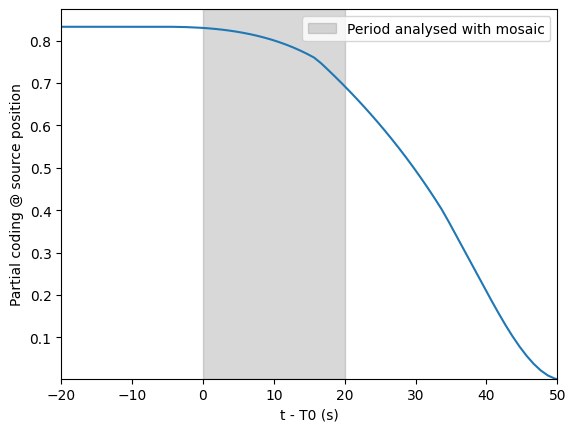

In [95]:

fit_file = next((fname for fname in os.listdir(workdir) if 'ext_loc' in fname), None)
ra_max, dec_max = derive_most_probable_position(fit_file, workdir)

print(f"Most probable position: RA={ra_max}, Dec={dec_max}")

def pc_time(ra, dec, event, t0, timebins, workdir):

    fig = plt.figure()

    import swiftbat

    object_batsource = swiftbat.source(
        ra=ra, dec=dec, name='pc_time'
    )

    time = event.attitude.time.value - t0*np.ones(len(event.attitude.time))

    exposures = np.array(
        [object_batsource.exposure(ra=ra,
                                dec=dec, 
                                roll=roll)[0]
            for ra,dec,roll in zip(event.attitude.ra,event.attitude.dec,event.attitude.roll)
        ])

    plt.plot(time,exposures/exp_area)
    plt.xlim(-20,50)
    time_window_mask = (time >= -20) & (time <= 50)
    plt.ylim(min(exposures[time_window_mask]/exp_area)*0.95,
              max(exposures[time_window_mask]/exp_area)*1.05) 
    plt.axvspan(timebins[0].value, timebins[1].value, color='gray', alpha=0.3,
                 label="Period analysed with mosaic")
    plt.legend()
    plt.xlabel('t - T0 (s)')
    plt.ylabel('Partial coding @ source position')
    plt.savefig(os.path.join(workdir, 'pc_time.png'), dpi=300)


pc_time(ra_max, dec_max, event, t0, [0, +20]*u.s, workdir)

## Count Rate light curve

We define here a function to read event data fits file

In [96]:
import astropy.io.fits as fits

def load_event_times(filename):
    with fits.open(filename) as hdul:
        for hdu in hdul:
            if hdu.name == "EVENTS":
                event_times = hdu.data["TIME"]
            if hdu.name == "GTI":
                gti_start = hdu.data["START"]
                gti_stop = hdu.data["STOP"]
    return event_times, gti_start, gti_stop


The filtered event data gives Good Time Intervals, namely intervals where data are reliable. The following function creates a mask to select counts only during GTIs

In [97]:

def bin_light_curve(times, bin_size, gti_start, gti_stop, t0):

    time_min = t0 - 50  # Start time for binning
    time_max = t0 + 150  # End time for binning

    # Create bins from time_min to time_max
    bins = np.arange(time_min, time_max + bin_size, bin_size)
    bin_centers = bins[:-1] + 0.5 * bin_size

    # Find mask for good bins (not intersecting with any bad interval)
    good_mask = np.ones_like(bin_centers, dtype=bool)
    # Vectorized GTI mask: keep bins fully inside any GTI interval
    left_edges = bin_centers - 0.5 * bin_size
    right_edges = bin_centers + 0.5 * bin_size

    # For each bin, check if it is fully inside any GTI interval
    # This creates a (n_bins, n_gti) boolean array
    in_gti = (left_edges[:, None] >= gti_start[None, :]) & (right_edges[:, None] <= gti_stop[None, :])
    good_mask = np.any(in_gti, axis=1)

    # Histogram counts for all bins
    counts, _ = np.histogram(times, bins=bins)

    # Select only good bins and corresponding counts
    bin_centers_good = bin_centers[good_mask]
    counts_good = counts[good_mask]

    return bin_centers_good, counts_good


### Background fitting

In [98]:
! pip install emcee 
import emcee
import multiprocessing
from scipy.optimize import curve_fit
from scipy.special import gammaln
from tqdm import tqdm

def poly3_func(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

def model(xx, t0, best_params, norm_val):
    return poly3_func(xx - t0, *best_params) * norm_val


def fit_background_linear(bin_centers, counts, t0):

    x = bin_centers
    '''

    Change the following line to define properly the background interval. In this case
    we are using -50s to t0-5s and t0+20s to t0+150s for background fitting.

    '''
    mask = ((x >= t0 - 50) & (x < t0 - 5)) | ((x > t0 + 20) & (x <= t0 + 150))

    x_fit = x[mask]
    counts_fit = counts[mask]
    # Normalize counts by the median of the pre-t0 region for stability
    x0 = x_fit - t0
    norm_val = np.median(counts_fit)
    if norm_val == 0:
        norm_val = 1  # Prevent division by zero
    y = counts_fit / norm_val


    p0 = [0, 0, 0, np.mean(y)]
    popt, _ = curve_fit(poly3_func, x0, y, p0=p0)

    
    # Prepare data for MCMC: x0, y, and errors
    yerr = np.sqrt(np.abs(y))
    yerr[yerr == 0] = 1.0  # Avoid zero errors

    def log_prior(theta):
        a, b, c, d = theta
        # Wide but reasonable priors
        if popt[0]-10 < a < popt[0]+10 and popt[1]-10 < b < popt[1]+10 and popt[2]-10 < c < popt[2]+10 and 0.1 * popt[3] < d < 10 * popt[3]:
            return 0.0
        return -np.inf

    def log_likelihood(theta, x, y):
        # Poisson log-likelihood for counts data
        model = poly3_func(x, *theta)
        model = np.clip(model, 1e-6, None)  # Avoid log(0)
        # Scale back to original counts
        model_counts = model * norm_val
        y_counts = y * norm_val
        # Use gammaln for log-factorial
        return np.sum(y_counts * np.log(model_counts) - model_counts - gammaln(y_counts + 1))

    def log_probability(theta, x, y):
        lp = log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(theta, x, y)

    ndim, nwalkers = 4, 32
    # Initial guess near least squares
    p0_ls, _ = curve_fit(poly3_func, x0, y, p0=[0, 0, 0, np.mean(y)])
    p0 = p0_ls + 1e-4 * np.random.randn(nwalkers, ndim)

    ncores = multiprocessing.cpu_count()
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x0, y), threads=ncores)
    # Add a progress bar using tqdm
    try:
        nsteps = 1000 # Number of MCMC steps, not so many to avoid long runtimes
        for _ in tqdm(range(nsteps), desc="MCMC sampling"):
            sampler.run_mcmc(p0, 1, progress=False)
            p0 = sampler.get_last_sample().coords
    except ImportError:
        # Fallback to normal run if tqdm is not available
        sampler.run_mcmc(p0, 1000, progress=True)
    samples = sampler.get_chain(discard=200, flat=True)

    # Best fit: parameters with maximum posterior likelihood
    log_probs = np.array([log_probability(theta, x0, y) for theta in samples])
    best_params = samples[np.argmax(log_probs)]

    print( f'Best fit mcmc parameters: {best_params}' )

    return best_params, samples, norm_val

### Search of time seeds for the analysis

For different time bins, we compute the signal to noise ratio (SNR), knowing the level of background. The formula for each time bin i is

$$
SNR_i = \frac{C_i - B_i}{\sqrt{C_i + B_i}}
$$

In [99]:
from matplotlib.patches import Patch

def find_seeds(bin_centers, counts, model_bkg, counts_sub, bin_size_ms, t0, workdir, samples, norm_val):

    plt.figure(figsize=(15, 5))
    x = bin_centers - t0
    errors = np.sqrt(counts)

    # Find indices where the gap is large
    gaps = np.where(np.diff(x) > 1.1*bin_size_ms/1000)[0]

    # Split indices into contiguous segments
    segments = np.split(np.arange(len(x)), gaps + 1)

    # Plot non-background-subtracted light curve (step only)
    plt.figure(figsize=(10, 5))
    x = bin_centers - t0
    for seg in segments:
        plt.step(x[seg], counts[seg], where='mid', color='black', alpha=0.6)


    # Plot 90% confidence band for background model using MCMC samples
    n_samples = 1000
    if samples.shape[0] > n_samples:
        idx = np.random.choice(samples.shape[0], n_samples, replace=False)
        sample_subset = samples[idx]
    else:
        sample_subset = samples

    model_curves = np.array([model(bin_centers, t0, params, norm_val) for params in sample_subset])
    lower = np.percentile(model_curves, 5, axis=0)
    upper = np.percentile(model_curves, 95, axis=0)
    plt.fill_between(x, lower, upper, color='red', alpha=0.2)
    plt.plot(x, model_bkg, color='red', linestyle='-', linewidth=2, label='Background model')
    plt.axvline(0, color='gray', linestyle='--', label='t0')
    plt.title(f"Raw Light Curve (binning: {bin_size_ms} ms)")
    plt.xlabel("Time [s] (t - t0)")
    plt.ylabel("Counts per bin")
    plt.legend()
    plt.grid(True)
    tmax = 150
    plt.xlim(-50, tmax)
    mask = (x >= -50) & (x <= tmax)
    ymin, ymax = counts[mask].min(), counts[mask].max()
    yrange = ymax - ymin
    plt.ylim(ymin - 0.1 * yrange, ymax + 0.1 * yrange)
    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(workdir, f"light_curve_raw_{bin_size_ms}ms.png"), dpi=300)
    plt.close()

    plt.figure(figsize=(15, 5))

    for seg in segments:
        plt.step(x[seg], counts_sub[seg], where='mid', color='blue', alpha=0.6)


    # Overlay error bars
    plt.errorbar(x, counts_sub, yerr=errors, fmt='o', color='blue', alpha=0.6, label='BKG-subtracted', markersize=3, capsize=2)

    snr = np.zeros_like(counts_sub, dtype=float)

    mask = (x < -5) | (x > 20)
    if np.any(mask):
        bkg_std = np.std(counts_sub[mask])
    else:
        bkg_std = np.std(counts_sub)


    with np.errstate(divide='ignore', invalid='ignore'):
        snr = counts_sub / (model_bkg + counts)**0.5
        snr[snr < 0] = 0

    print(f'Max SNR: {snr.max()}')
    # Normalize SNR for colormap (clip at 0, max in window for visualization)
    snr_max = snr.max() 
    snr_clipped = np.clip(snr, 0, snr_max)
    cmap = plt.get_cmap('GnBu')
    norm = plt.Normalize(0, snr_max)

    # Prepare to add legend for hatching

    hatch_legend_added = False
    double_hatch_legend_added = False
    for i, xc in enumerate(x):
        color = cmap(norm(snr_clipped[i]))
        if snr[i] > 3.5:
            plt.axvspan(
                xc - bin_size_ms/2000.0,
                xc + bin_size_ms/2000.0,
                color=color,
                alpha=0.3,
                zorder=1,
                label='SNR > 3.5' if not hatch_legend_added else None
            )
            hatch_legend_added = True
        # No shading for SNR <= 3.5

    # Add custom legend handles for hatching if not present
    handles, labels = plt.gca().get_legend_handles_labels()
    if 'SNR > 3.5' not in labels:
        handles.append(Patch(facecolor='none', edgecolor='black', hatch='/', label='SNR > 3.5'))
    plt.legend(handles=handles, labels=[h.get_label() for h in handles])

    # Add color bar for SNR
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    ax = plt.gca()
    cbar = plt.colorbar(sm, pad=0.01, ax=ax, alpha=0.3)
    cbar.set_label('SNR')

    # Highlight spikes
    # for spike_center in bin_centers[spikes[0]]:
    #     spike_x = spike_center - t0
    #     plt.axvspan(spike_x - bin_size_ms/2000.0, spike_x + bin_size_ms/2000.0, color='red', alpha=0.3, label='Spikes' if 'Spikes' not in plt.gca().get_legend_handles_labels()[1] else None, zorder=4)

    plt.title(f"Light Curve (binning: {bin_size_ms} ms)")
    plt.xlabel("Time [s] (t - t0)")
    plt.ylabel("Counts per bin")
    
    plt.axhline(0, color='gray', linestyle=':', linewidth=1)

    max_snr_val = snr.max()
    max_snr_idx = np.where(snr == max_snr_val)[0][0]
    t_star = bin_centers[max_snr_idx] - t0  # Time of maximum SNR

    window = min(45, 30 * bin_size_ms / 1000.0)  # Set window size based on bin size
    plt.xlim(t_star - window, t_star + window)
    mask = (x >= -window) & (x <= window)

    # Add horizontal bands for 3.5 and 5 sigma of background

    plt.axhspan(-3.5 * bkg_std, 3.5 * bkg_std, color='blue', alpha=0.1)
    plt.axhspan(-5 * bkg_std, 5 * bkg_std, color='blue', alpha=0.1, label='3.5σ and 5σ')
    plt.autoscale(axis='y')
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(workdir, f"light_curve_{bin_size_ms}ms.png"), dpi=300)


    if max_snr_val > 4.0:
        return bin_centers[max_snr_idx] - t0, max_snr_val
    return None, None

In [100]:

def cust_seeds(t0, workdir):

    filename = os.path.join(workdir, 'filter_evdata.fits')
    #filename = str(event.event_files) # uncomment this to check what happens with the non-filtered event file
    event_times, gti_start, gti_stop = load_event_times(filename)

    snr_max = 0
    seed_max = None
    seeds = []


    for bin_size_ms in [64, 512, 1024, 4096]:

        try:
            bin_size = bin_size_ms / 1000.0
            bin_centers, counts = bin_light_curve(event_times, bin_size, gti_start, gti_stop, t0)
            if len(bin_centers) < 20:
                logging.info(f'Not enough bins for bin size {bin_size_ms} ms, skipping...')
                continue

            best_params, samples, norm_val  = fit_background_linear(bin_centers, counts, t0)
            model_bkg = model(bin_centers, t0, best_params, norm_val)
            
            counts_sub = counts - model_bkg

            # Detect spikes
            time_bin, snr_bin = find_seeds(bin_centers, counts, model_bkg, counts_sub, bin_size_ms, t0, workdir, samples, norm_val)
            print(f'Bin size: {bin_size_ms} ms, Seed time: {time_bin}, SNR: {snr_bin}', flush=True)
            if time_bin is not None or snr_bin is not None:
                if snr_bin > 4.0:
                    seeds.append([time_bin, bin_size_ms, snr_bin])
                if snr_bin > snr_max:
                    seed_max, dur_max, snr_max = time_bin, bin_size_ms, snr_bin
        except Exception as e:
            # logging.error(f'Error processing bin size {bin_size_ms} ms: {traceback.format_exc()}')
            continue
    print(f'Max SNR: {snr_max} found at time {seed_max} with duration {dur_max} ms', flush=True)


MCMC sampling: 100%|██████████| 1000/1000 [00:04<00:00, 218.42it/s]


Best fit mcmc parameters: [ 2.18579754e-08 -9.85098852e-07 -3.31733104e-04  1.01221607e+00]


<Figure size 1500x500 with 0 Axes>

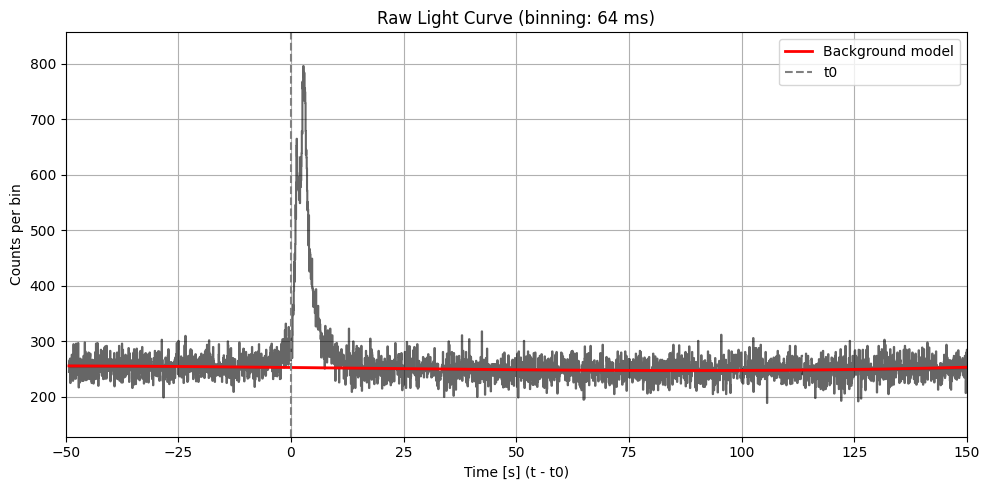

Max SNR: 16.77222143278643


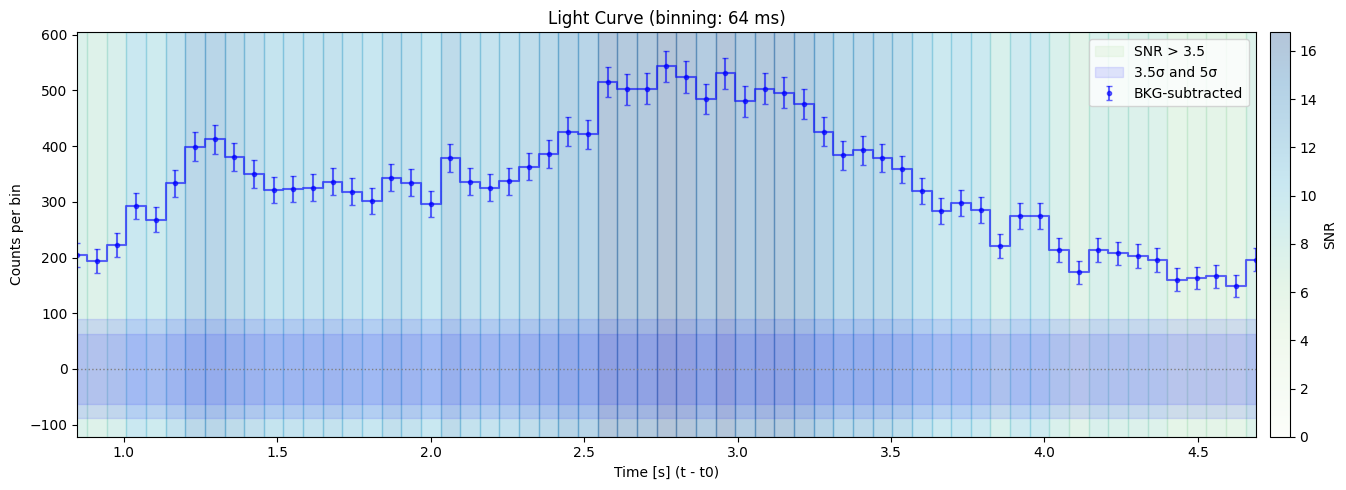

Bin size: 64 ms, Seed time: 2.768008589744568, SNR: 16.77222143278643


MCMC sampling: 100%|██████████| 1000/1000 [00:01<00:00, 725.08it/s]


Best fit mcmc parameters: [ 2.38927431e-08 -1.32306375e-06 -3.25579603e-04  1.01024361e+00]


<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

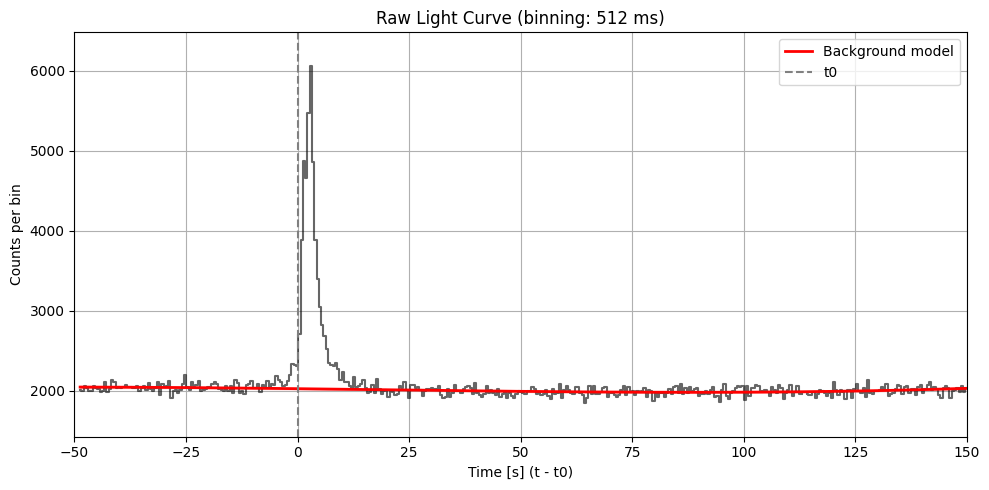

Max SNR: 44.91156638236836


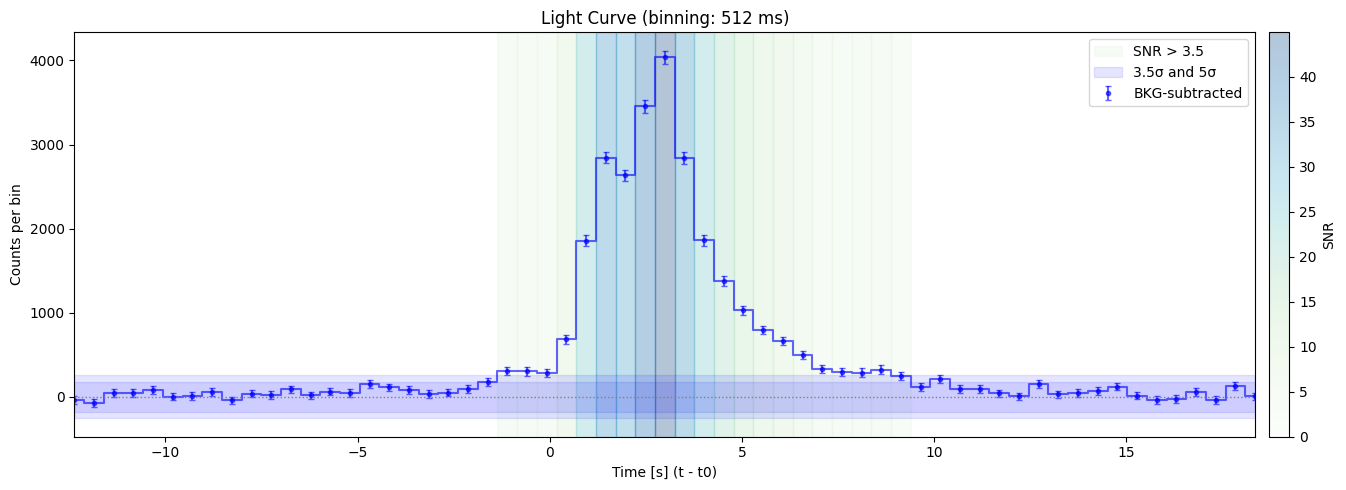

Bin size: 512 ms, Seed time: 2.99199640750885, SNR: 44.91156638236836


MCMC sampling: 100%|██████████| 1000/1000 [00:01<00:00, 846.45it/s]


Best fit mcmc parameters: [ 2.25026109e-08 -1.08614546e-06 -3.29412154e-04  1.00947346e+00]


<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

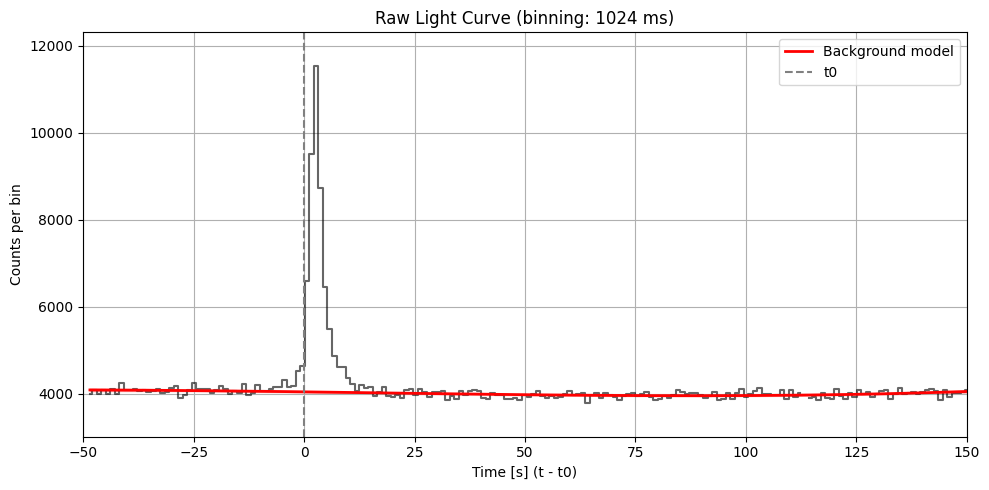

Max SNR: 60.02731180359651


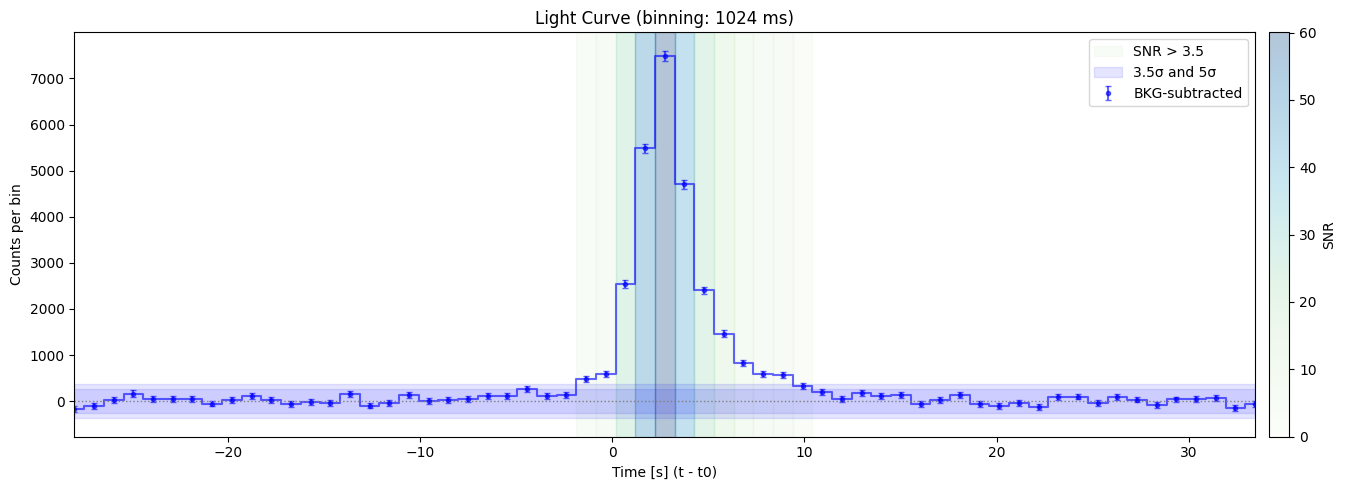

Bin size: 1024 ms, Seed time: 2.7360024452209473, SNR: 60.02731180359651


MCMC sampling: 100%|██████████| 1000/1000 [00:00<00:00, 1007.14it/s]


Best fit mcmc parameters: [ 2.06219305e-08 -5.88004768e-07 -3.63975838e-04  1.01446877e+00]


<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

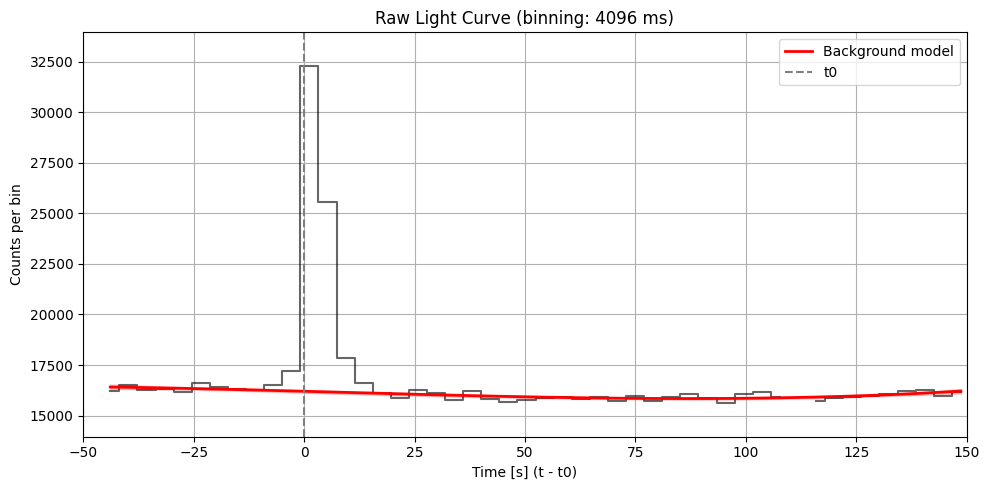

Max SNR: 73.10897379848099


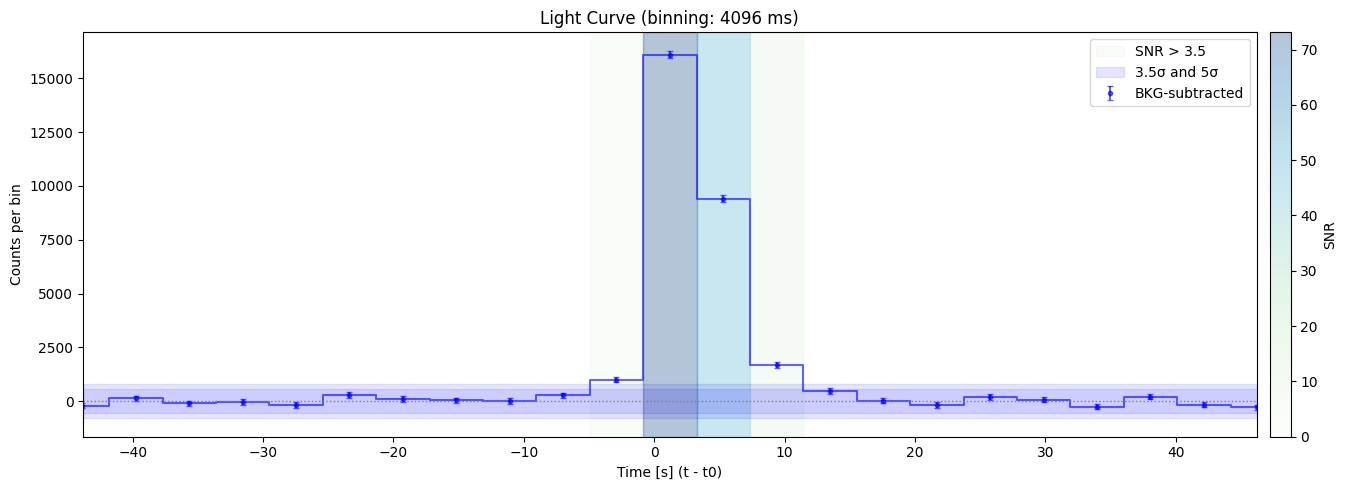

Bin size: 4096 ms, Seed time: 1.199999451637268, SNR: 73.10897379848099
Max SNR: 73.10897379848099 found at time 1.199999451637268 with duration 4096 ms


<Figure size 640x480 with 0 Axes>

In [101]:
cust_seeds(t0, workdir)

## Mosaic

In [102]:
def log_mosaic(mosaic_detected_sources):
    try:
        _mosaic_table_header = "{:<3} {:>10} {:>10} {:>10} {:>20}".format(
        "Idx", "SNR", "RA", "DEC", "psffwhm_separation"
        )
        _mosaic_table_rows = []
        if mosaic_detected_sources is not None:
            for _mosaic_idx, _mosaic_src in enumerate(mosaic_detected_sources):
                _mosaic_snr = _mosaic_src.get('SNR', None)
                _mosaic_coord = _mosaic_src.get('SNR_skycoord', None)
                _mosaic_ra = f"{_mosaic_coord.ra.deg:10.3f}" if _mosaic_coord is not None else "   None"
                _mosaic_dec = f"{_mosaic_coord.dec.deg:10.3f}" if _mosaic_coord is not None else "   None"
                _mosaic_psf_sep = f"{_mosaic_src.get('psffwhm_separation', None):20.3f}" if _mosaic_src.get('psffwhm_separation', None) is not None else "        None"
                _mosaic_table_rows.append(
                    "{:<3} {:>10} {} {} {}".format(
                    _mosaic_idx,
                    f"{_mosaic_snr:10.3f}" if _mosaic_snr is not None else "     None",
                    _mosaic_ra,
                    _mosaic_dec,
                    _mosaic_psf_sep
                    )
                )
            _mosaic_table_str = "\n".join([_mosaic_table_header] + _mosaic_table_rows)
            # print(_mosaic_table_str)
            logging.info("Mosaic detected sources (SNR, coords, psffwhm_separation):\n" + _mosaic_table_str)
        else:
            logging.info("No mosaic detected sources found.")
    except Exception as _mosaic_exc:
        logging.error(f"Error logging detected sources table: {traceback.format_exc()}")

In [134]:

time_bins = np.arange(1, 3, 0.2)*u.s
energybins = [15, 350]*u.keV
skyview_nprocs = 10
healpix_nside = 512
mosaic_nprocs = 10

import os
from joblib import parallel_backend

joblib_tmp = os.path.join(workdir, "joblib_tmp")
os.makedirs(joblib_tmp, exist_ok=True)
os.environ["JOBLIB_TEMP_FOLDER"] = joblib_tmp

n_procs = 10

with parallel_backend(
    'loky',
    n_jobs=n_procs,
    max_nbytes=None,             
    inner_max_num_threads=1,      
    temp_folder=joblib_tmp
):

    slew_skyviews=ba.parallel.create_event_skyview(event, timebins=time_bins, energybins=energybins, 
                                                recalc = True, is_relative=True, parse_images = False, 
                                                T0=t0, nprocs=skyview_nprocs, 
                                                input_dict=dict(aperture="CALDB:DETECTION", pcodethresh=0.01))

    mosaic_skyview = ba.parallel.mosaic_skyview(slew_skyviews, healpix_nside=healpix_nside,
                                                healpix_coordsys="icrs", nprocs=mosaic_nprocs)
mosaic_detected_sources = mosaic_skyview.detect_sources(input_dict=dict(pcodethresh=0.01, snrthresh=5.5))


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Invalid parameter values: MJD-OBS and DATE-OBS are inconsistent.
Set MJD-END to 59401.347708 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Invalid parameter values: MJD-OBS and DATE-OBS are inconsistent.
Set MJD-END to 59401.347708 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Invalid parameter values: MJD-OBS and DATE-OBS are inconsistent.
Set MJD-END to 59401.347708 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Invalid parameter values: MJD-OBS and DATE-OBS are inconsistent.
Set MJD-END to 59401.347708 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Invalid parameter values: MJD-OBS and DATE-OBS are inconsistent.
Set MJD-END to 59401.347708 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is 

In [135]:
log_mosaic(mosaic_detected_sources)

2025-12-18 15:07:59,236 - INFO - Mosaic detected sources (SNR, coords, psffwhm_separation):
Idx        SNR         RA        DEC   psffwhm_separation
0       35.908    311.924     13.401               12.001
1       32.670    312.012     13.325               11.808
2       32.613    311.836     13.325               12.258
3       30.800    311.924     13.248               12.069
4       23.265    312.012     13.478               11.745
5       22.182    311.836     13.478               12.198
6       20.196    312.100     13.401               11.549
7       19.681    311.748     13.401               12.453
8       17.514    312.100     13.248               11.619
9       17.428    311.748     13.248               12.519
10      17.418    312.012     13.171               11.884
11      16.851    311.836     13.171               12.332
12      15.191    311.924     13.555               11.946
13      10.354    311.660     13.325               12.710
14      10.083    312.187     13.325  

## Plot the results

In [108]:
from matplotlib.lines import Line2D
from astropy.modeling.models import Gaussian1D

def map_mosaic(ra_s, dec_s, workdir, skyview):

    fig = plt.figure()
   
    ax_zoom_rect = plt.axes([-1.2, 0.0, 0.9, 0.9],projection='astro degrees zoom',
                center=f'{ra_s}d {dec_s}d', radius='2 deg')
    

    ax_globe = plt.axes(
        [-0.3, -0.05, 1.25, 1.25],
        projection='astro degrees mollweide',
        )
    
    ax_globe.grid()

    ax_hist = fig.add_axes([1.1, 0.2, 0.5, 0.8])  # [left, bottom, width, height]


    '''
    The hp_proj object contains the healpix projection of the sky image.
    It is an array that contains [time, sky pixel, energy band]. 
    Since we created a single sky image for a single time bin and a single energy band,
    we can extract the first time and first energy band to get the sky map.
    '''
    t = skyview.snr_img # loading the sky image already done outside
    hp_proj = t.healpix_projection(coordsys="icrs", nside=healpix_nside) # projecting in healpix (from detector coords to sky coords)

    snr_map = hp_proj.contents[0,:,0]
    ax_zoom_rect.imshow_hpx((snr_map, 'ICRS'),  cmap="magma", alpha=1.0, zorder=1)

    '''
    We load again the partial coding image to overplot the contours
    '''

    col = ['orange', 'blue', 'green']

    time_bins=[[-10,-9],[-1,+1],[10,11]]*u.s
    for n in range(0,3):
        settled_skyview = event.create_skyview(timebins=time_bins[n], energybins= [15, 350]*u.keV, is_relative=True, T0=t0)
        x = settled_skyview.pcode_img.healpix_projection(coordsys="icrs", nside=1024).contents[0,:,0]
        ax_globe.contour_hpx((x, 'ICRS'), nested=False, colors=col[n], levels=[0.1], linewidths=1, zorder=2)

 
    '''
    We finally create the histogram of the SNR values
    '''

    h = skyview.snr_img.contents.flatten()
    val, _, _=plt.hist(h, bins=100, alpha=0.8, color='blue', label='SNR histogram', histtype='step')
    
    max_snr_value = np.nanmax(h)
    min_snr_value = np.nanmin(h)
    ax_hist.axvline(max_snr_value, color='red', linestyle='--', label=f'Max SNR: {max_snr_value:.2f}')

    g = Gaussian1D(amplitude=val.max(), stddev=1)
    x = np.arange(-30, 30, .01)
    ax_hist.plot(x, g(x), 'k-')

    # Here some aestethic adjustments

    ax_zoom_rect.coords[0].set_major_formatter('d.d')  # 3 decimal degrees
    ax_zoom_rect.coords[1].set_major_formatter('d.d')  # 3 decimal degrees
    ax_zoom_rect.grid()
    vmin= np.nanmin(snr_map)
    vmax=np.nanmax(snr_map)
    cmap_custom = plt.cm.inferno
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap_custom, norm=norm)
    cbar = plt.colorbar(sm, ax=ax_zoom_rect, shrink=0.5, orientation='horizontal', aspect=30, pad=0.15)
    cbar.mappable.set_clim(vmin=vmin,vmax=vmax)
    cbar.set_label('SNR')

    ax_globe.grid()
    ax_globe.mark_inset_axes(ax_zoom_rect)
    ax_globe.connect_inset_axes(ax_zoom_rect, 'upper right')
    ax_globe.connect_inset_axes(ax_zoom_rect, 'lower right')


    ax_hist.set_xlabel('')
    ax_hist.set_ylabel('Counts')
    ax_hist.set_ylabel('SNR')
    ax_hist.set_yscale('log')
    ax_hist.yaxis.tick_right()
    ax_hist.yaxis.set_label_position("right")
    ax_hist.set_ylim([0.1,2*val.max()])
    ax_hist.set_xlim([min_snr_value-1,max_snr_value+1])
    ax_hist.legend(
        loc='upper right')
    

    fov_line = [Line2D([0], [0], color='orange', linestyle='solid', linewidth=2, label='FOV @ $t_0$ - 10 s' ),
    Line2D([0], [0], color='blue', linestyle='solid', linewidth=2, label='FOV @ $t_0$'),
    Line2D([0], [0], color='green', linestyle='solid', linewidth=2, label='FOV @ $t_0$ + 10 s')]


    fit_file = next((fname for fname in os.listdir(workdir) if 'ext_loc' in fname), None)
    loc_handles = None
    if fit_file:
        loc_handles = map_ext(fit_file, workdir, ax_globe)


    if loc_handles is not None:
        leg_ext = ax_globe.legend(handles=loc_handles, loc='lower left', frameon=True, bbox_to_anchor=(-0.1, -0.15), borderaxespad=0.5)
        ax_globe.add_artist(leg_ext)

    ax_leg_bot = fig.add_axes([0.76, 0.0, 0.22, 0.28])
    ax_leg_bot.axis('off')

    fov_legend = ax_leg_bot.legend(handles=fov_line, loc='lower left', frameon=True, borderaxespad=0.5)
    ax_leg_bot.add_artist(fov_legend)

    plt.savefig(os.path.join(workdir,'map_mosaic.png'), bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()


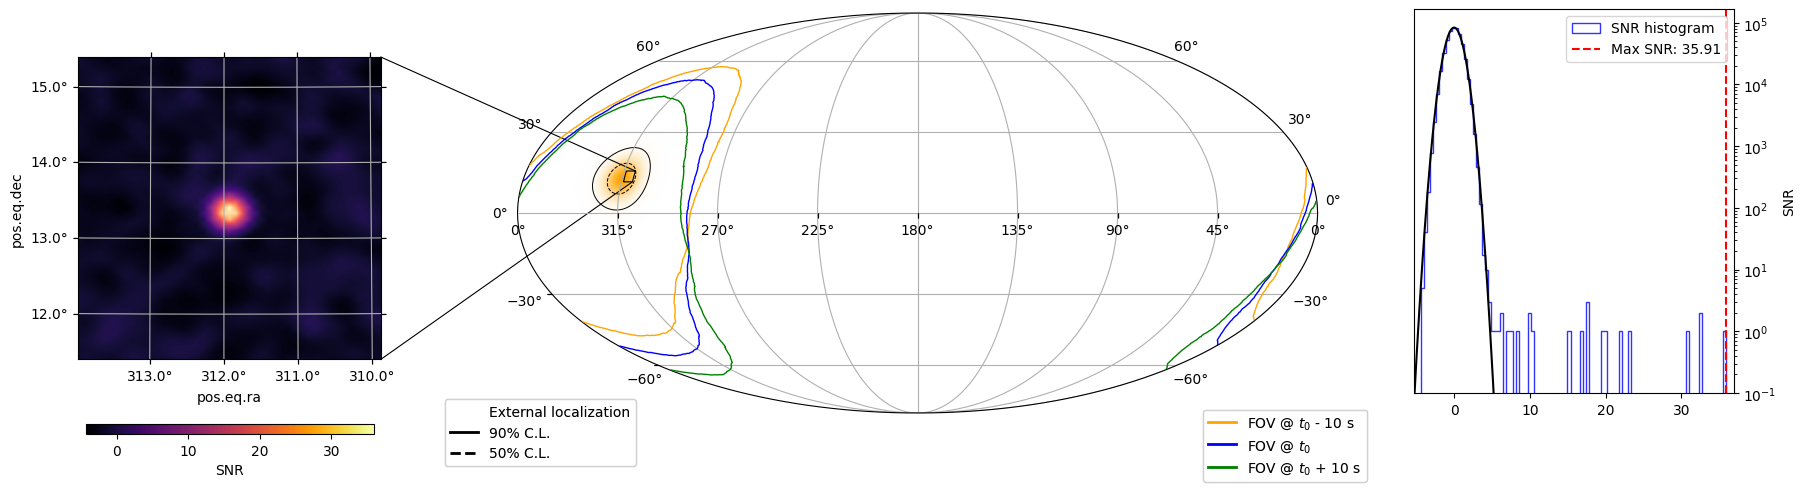

In [109]:
ra_mos, dec_mos = mosaic_detected_sources[0]['SNR_skycoord'].ra.deg, mosaic_detected_sources[0]['SNR_skycoord'].dec.deg

map_mosaic(ra_mos, dec_mos, workdir, mosaic_skyview)

## Looking at the DPI

In [110]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_dpi(self, mask_value = None, emin=None, emax=None, tmin=None, tmax=None, plot_rate=False):
        """
        This method allows the user to conveniently plot the histogram for a single energy bin and time interval.
        Any detectors with 0 counts (due to detectors being off or due to there being no detectors in the specified
        DETX and DETY coordinates) are blacked out.

        By default, the histogram is binned along the energy and time axes. This behavior can be changed by specifying
        emin/emax and/or tmin/tmax. These values should all exist in the ebins and tbins attributes.

        :param emin: None or an astropy Quantity array of the beginning of the energy bins
        :param emax: None or an astropy Quantity array of the end of the energy bins
        :param tmin: None or an astropy Quantity array of the starting time bin edges that the histogram will be
            rebinned into
        :param tmax: None or an astropy Quantity array of the end time bin edges that the histogram will be
            rebinned into
        :param plot_rate: Boolean to denote if the count rate should be plotted. The histogram gets divided by the
            exposure time of the plotted histogram
        :return: matplotlib figure and axis for the plotted histogram
        """

        if emin is None and emax is None:
            plot_emin = self.ebins["E_MIN"].min()
            plot_emax = self.ebins["E_MAX"].max()
        elif emin is not None and emax is not None:
            plot_emin = emin
            plot_emax = emax
        else:
            raise ValueError(
                "emin and emax must either both be None or both be specified."
            )
        plot_e_idx = np.where(
            (self.ebins["E_MIN"] >= plot_emin) & (self.ebins["E_MAX"] <= plot_emax)
        )[0]

        if tmin is None and tmax is None:
            plot_tmin = self.tbins["TIME_START"].min()
            plot_tmax = self.tbins["TIME_STOP"].max()
        elif tmin is not None and tmax is not None:
            plot_tmin = tmin
            plot_tmax = tmax
        else:
            raise ValueError(
                "tmin and tmax must either both be None or both be specified."
            )
        plot_t_idx = np.where(
            (self.tbins["TIME_START"] >= plot_tmin)
            & (self.tbins["TIME_STOP"] <= plot_tmax)
        )[0]

        # now start to accumulate the DPH counts based on the time and energy range that we care about
        plot_data = self.contents[plot_t_idx, :, :, :]

        if len(plot_t_idx) > 0:
            plot_data = plot_data.sum(axis=0)
        else:
            raise ValueError(
                f"There are no DPH time bins that fall between {plot_tmin} and {plot_tmax}"
            )

        plot_data = plot_data[:, :, plot_e_idx]

        if len(plot_e_idx) > 0:
            plot_data = plot_data.sum(axis=-1)
        else:
            raise ValueError(
                f"There are no DPH energy bins that fall between {plot_emin} and {plot_emax}"
            )

        if plot_rate:
            # calcualte the totoal exposure
            exposure_tot = np.sum(self.exposure[plot_t_idx])
            plot_data /= exposure_tot

        # set any 0 count detectors to nan so they get plotted in black
        # this includes detectors that are off and "space holders" between detectors where the value is 0
        plot_data[plot_data == 0] = np.nan
        
        mask = (plot_data.value < mask_value[0]) | (plot_data.value > mask_value[1])
        plot_data[mask] = np.nan

        data = plot_data.flatten()
        data = data[data != 0]
        data = data.value

        # Create the figure with two subplots: main image and histogram
        fig, (ax, ax_hist) = plt.subplots(
            1, 2,
            figsize=(12, 5),  # wider figure
            gridspec_kw={'width_ratios': [4, 2]}  # more space for histogram
        )

        # Main image panel
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)

        cmap = plt.colormaps.get_cmap("viridis")
        cmap.set_bad(color="k")

        im = ax.imshow(plot_data.value, origin="lower", interpolation="none", cmap=cmap)
        fig.colorbar(im, cax=cax, orientation="vertical", label=plot_data.unit)

        ax.set_ylabel("DETY")
        ax.set_xlabel("DETX")

        # Histogram panel
        # Compute bin edges so that bins are centered at 1, 2, 3, ... (integers)
        min_center = 0
        max_center = int(np.ceil(np.nanmax(data)))
        bin_centers = np.arange(min_center, max_center + 1)
        bins = bin_centers - 0.5
        bins = np.append(bins, bins[-1] + 1)
        ax_hist.hist(data, bins=bins, color="gray", histtype="step", edgecolor="black", label="Counts")
        ax_hist.set_xlabel("Counts per detector")
        ax_hist.set_yscale("log")
        ax_hist.grid(True)
        mean_val = np.nanmean(data)
        ax_hist.axvline(mean_val, color="red", linestyle="--", label="Mean = {:.2f}".format(mean_val))
        ax_hist.legend()

        plt.tight_layout(rect=[0, 0, 1, 0.8])  # Make space for suptitle

        return fig, ax

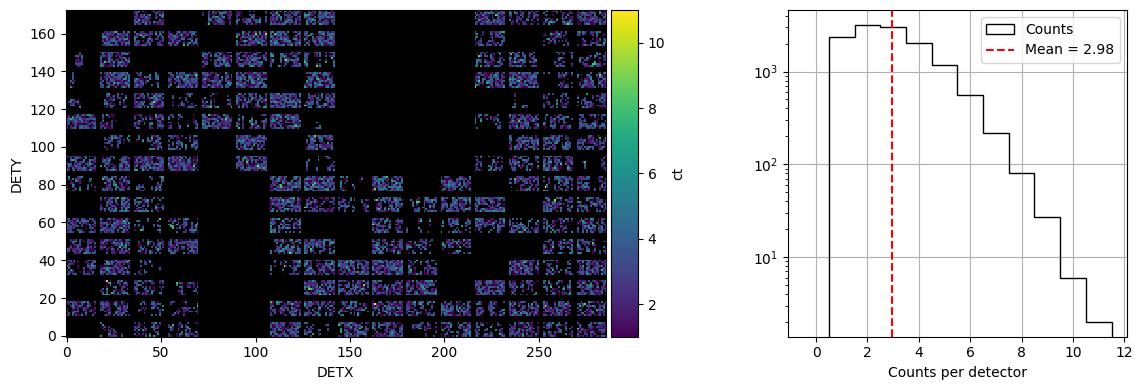

<Figure size 640x480 with 0 Axes>

In [111]:
time_bins=[-10,0]*u.s
energybins = [15, 350] * u.keV

event_dpi=event.create_dpi(timebins=time_bins, energybins=energybins, T0=t0, is_relative = True)

f = plot_dpi(event.dpis[-1], mask_value = [0, np.inf])
plt.show()
plt.savefig(os.path.join(workdir, 'dpi.png'), dpi=300, bbox_inches='tight')

2025-12-18 12:39:24,453 - INFO - Plotting DPI plot for time bins [ 0. 10.] s


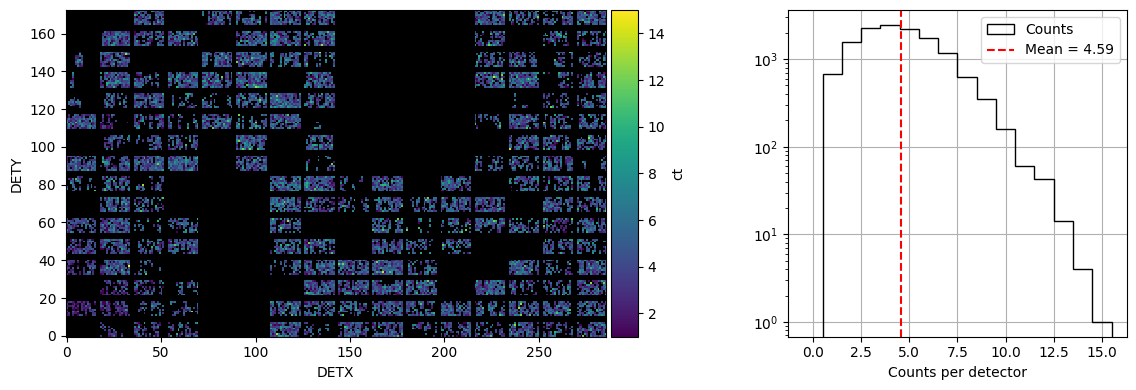

In [112]:
time_bins=[0,10]*u.s
logging.info(f'Plotting DPI plot for time bins {time_bins}')
energybins = [15, 350] * u.keV
event_dpi=event.create_dpi(timebins=time_bins, energybins=energybins, T0=t0, is_relative = True)
f = plot_dpi(event.dpis[-1], mask_value = [0, np.inf])
plt.show()

2025-12-18 12:39:24,813 - INFO - Plotting DPI plot for time bins [50. 60.] s


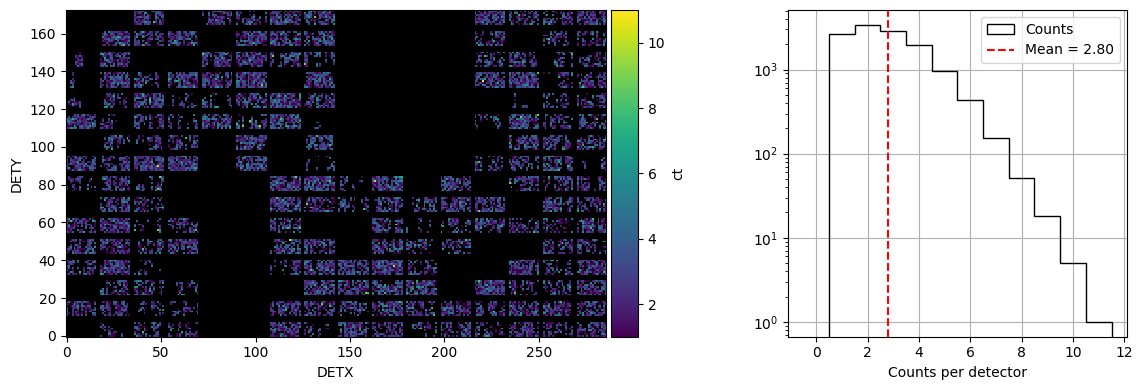

In [113]:
time_bins=[50,60]*u.s
logging.info(f'Plotting DPI plot for time bins {time_bins}')
energybins = [15, 350] * u.keV
event_dpi=event.create_dpi(timebins=time_bins, energybins=energybins, T0=t0, is_relative = True)
f = plot_dpi(event.dpis[-1], mask_value = [0, np.inf])
plt.show()

## Light curve after applying mask weighting

In [114]:
event.apply_mask_weighting(ra=ra_mos*u.deg, dec=dec_mos*u.deg)

Under the hood apply_mask_weighting does the following
```
input_dict = dict(
    infile=str(self.event_files),
    attitude=str(self.attitude_file),
    detmask=str(self.detector_quality_file),
    ra=ra.value,
    dec=dec.value,
    auxfile=str(temp_auxil_raytracing_file),
    clobber="YES",
)
batmaskwtevt_return = self._call_batmaskwtevt(input_dict)
```

In [115]:

def plot_lc(event, t0, deltat, workdir, pipe):

    lc = event.create_lightcurve(energybins=[15, 50, 100, 350] * u.keV)

    color = ['red','blue', 'green', 'black']
    label = ['15-50 keV', '50-100 keV', '100-350 keV', '15-350 keV']
    bin_sizes = [0.064, 0.256, 1.024]  # in seconds

    fig, axes = plt.subplots(len(bin_sizes), 1, figsize=(10, 5 * len(bin_sizes)), sharex=True)

    for i, bin_size in enumerate(bin_sizes):
        ax = axes[i]
        lc.set_timebins(
                    timebinalg="uniform",
                    timedelta=np.timedelta64(int(bin_size*1000), 'ms'),
                    tmin=-5*deltat*u.s,
                    tmax=10*deltat*u.s,
                    T0=t0,
                    is_relative = True)
        lc.set_energybins(energybins=[15, 50, 100, 350]* u.keV)
        # Now plot each sub-band
        for n in range(0,4):
            time = lc.data['TIME'][:].value
            counts = lc.data['RATE'][:,n].value
            errors = lc.data['ERROR'][:,n].value
            if n==3:
                ax.errorbar(time-t0, counts, yerr=errors, color=color[n], ls='', zorder=n, alpha=1.0)
                ax.step(time-t0, counts, where='mid', color=color[n], label=label[n], zorder=n, alpha=1.0)
            else:
                ax.step(time-t0, counts, where='mid', color=color[n], label=label[n], zorder=n, alpha=0.4)
        ax.set_title(f"Light Curve (bin size: {bin_size:.3f} s)")
        ax.axhline(y=0.0, color='r', linestyle='--', linewidth=1)
        ax.set_ylabel("Counts/bin")
        ax.legend()


    axes[-1].set_xlabel("Time [s] (t - t0)")
    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(workdir, f'lc_{pipe}.png'), dpi=300)
    plt.close()


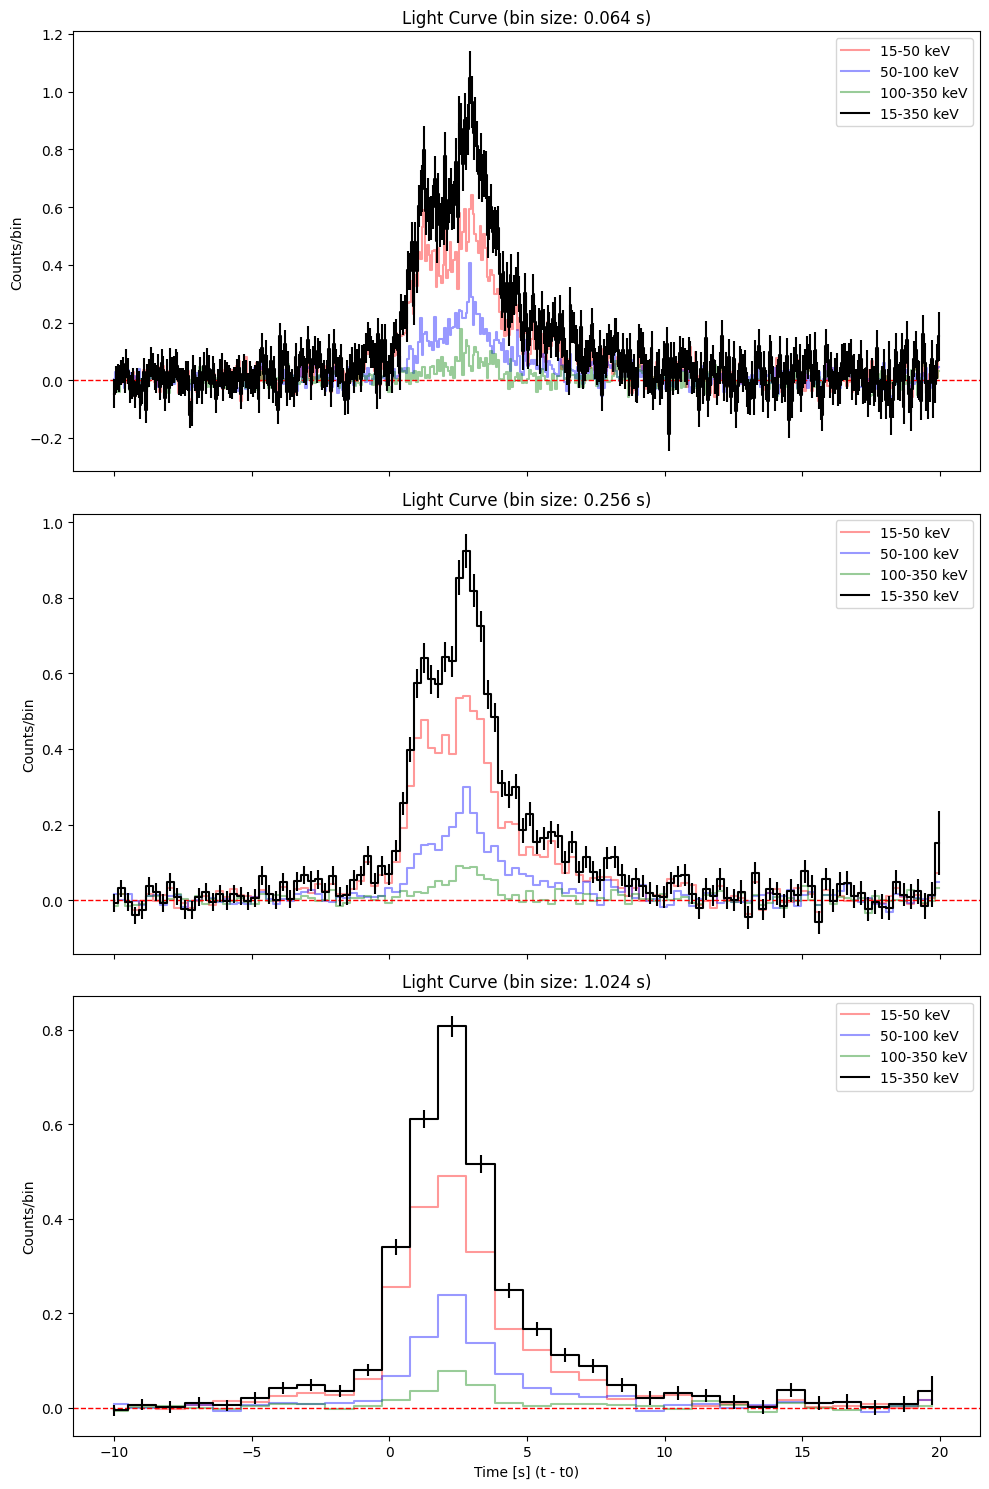

In [116]:
delta_t = 2  # typical duration in seconds of the event
plot_lc(event, t0, delta_t, workdir, 'mosaic')

## Bayesian blocks light curve

Text(0.5, 1.0, 'Bayesian Block Light Curve')

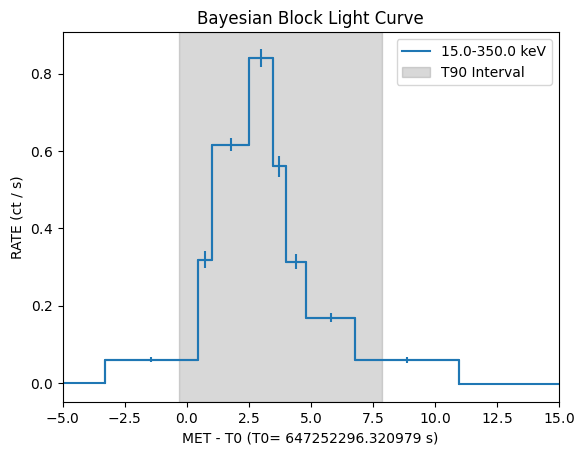

In [117]:
lc=event.create_lightcurve(energybins=[15, 350] * u.keV)
lc.set_timebins(timebinalg="bayesian", save_durations=True)

bayesian_tstart = lc.tbins["TIME_START"]
bayesian_tstop = lc.tbins["TIME_STOP"]
t90_start = lc.tdurs['T90']['TSTART']
t90_stop = lc.tdurs['T90']['TSTOP']
mask = (bayesian_tstop >= t90_start) & (bayesian_tstart <= t90_stop)

lc.plot(T0=t0, plot_relative=True)

# Highlight T90 interval
plt.axvspan(t90_start.value - t0, t90_stop.value - t0, color='gray', alpha=0.3, label='T90 Interval')
plt.legend()
plt.xlim(-5, 15)
plt.title("Bayesian Block Light Curve")

In [118]:
print(f"The t_90 duration is {lc.tdurs['T90']['TSTOP'] - lc.tdurs['T90']['TSTART']:.2f}")
print(f"Emission start time: {lc.tdurs['T90']['TSTART'].value - t0:.2f} seconds relative to t0")
print(f"Emission stop time: {lc.tdurs['T90']['TSTOP'].value - t0:.2f} seconds relative to t0")

The t_90 duration is 8.19 s
Emission start time: -0.30 seconds relative to t0
Emission stop time: 7.90 seconds relative to t0


## Spectrum during the $t_{90}$ interval (approximate method)

In [119]:
spectrum_t90_fake=event.create_pha(tstart=lc.tdurs['T90']['TSTART'],
                                    tstop=lc.tdurs['T90']['TSTOP'], recalc=True)


1 spectrum  in use
 
Spectral Data File: t_647252296.024-647252304.2159998_80chan.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.673e-01 +/- 8.905e-03
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 8.192 sec
 Using fit statistic: chi
 Using Response (RMF) File            t_647252296.024-647252304.2159998_80chan.rsp for Source 1


Fit statistic  : Chi-Squared                   64.01     using 80 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number: 1

Test statistic : Chi-Squared                   64.01     using 80 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 8.73e-01 with 78 degrees of freedom
 Current data and model not fit yet.

Model cflux<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     V

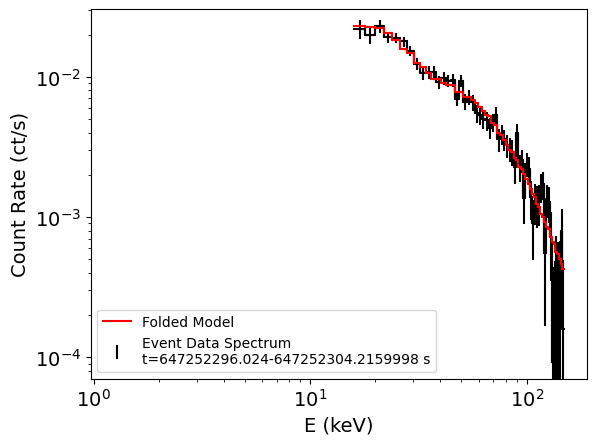

In [120]:
ba.fit_spectrum(spectrum_t90_fake, generic_model="cflux*po",
                setPars={1:"15,-1", 2:"150,-1",3:-9, 4:"-1",5:".001,-1"},
                use_cstat=False, fit_iterations=10000)

In [121]:
params = spectrum_t90_fake.spectral_model['parameters']
lg10_flux = params['lg10Flux']
flux = 10 ** lg10_flux['val']
flux_lo = 10 ** lg10_flux['lolim']
flux_hi = 10 ** lg10_flux['hilim']

print(f"Converted flux: best fit = {flux:.3e}, interval = ({flux_lo:.3e}, {flux_hi:.3e})")
# photon index
photon_index = params['PhoIndex']['val']
photon_index_lo = params['PhoIndex']['lolim']
photon_index_hi = params['PhoIndex']['hilim']

print(f"Photon index: best fit = {photon_index:.3f}, interval = ({photon_index_lo:.3f}, {photon_index_hi:.3f})")

Converted flux: best fit = 2.163e-07, interval = (2.088e-07, 2.238e-07)
Photon index: best fit = 1.610, interval = (1.547, 1.673)


## Spectrum during $t_{90}$ (correct way)

We first create a spectrum for each bayesian block and then we fit them

In [122]:
bayesian_spectra = event.create_pha(
    tstart=bayesian_tstart[mask],
    tstop=bayesian_tstop[mask],
    recalc=True
)

In [123]:
import os
from joblib import parallel_backend

joblib_tmp = os.path.join(workdir, "joblib_tmp")
os.makedirs(joblib_tmp, exist_ok=True)
os.environ["JOBLIB_TEMP_FOLDER"] = joblib_tmp

n_procs = min(len(bayesian_spectra), multiprocessing.cpu_count())

with parallel_backend(
    'loky',
    n_jobs=n_procs,
    max_nbytes=None,             
    inner_max_num_threads=1,      
    temp_folder=joblib_tmp
):
    output_bayesian_spectra = ba.parallel.batspectrum_TTE_analysis(
        bayesian_spectra,
        generic_model="cflux*po",
        setPars={1:"15,-1", 2:"150,-1", 3:-9, 4:"-1", 5:".001,-1"},
        nprocs=n_procs,
        use_cstat=False,
        fit_iterations=10000,
        recalc=True
    )


1 spectrum  in use
 
Spectral Data File: t_647252301.144-647252303.128_80chan.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.699e-01 +/- 1.262e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 1.984 sec
 Using fit statistic: chi
 Using Response (RMF) File            t_647252301.144-647252303.128_80chan.rsp for Source 1


1 spectrum  in use
 
Spectral Data File: t_647252303.128-647252307.2879999_80chan.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  6.266e-02 +/- 7.803e-03
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 4.16 sec
 Using fit statistic: chi
 Using Response (RMF) File            t_647252303.128-647252307.2879999_80chan.rsp for Source 1


Model cflux<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin

We extract the spectrum in the whole $t_{90}$ interval

In [124]:
spectrum_t90=event.create_pha(tstart=lc.tdurs['T90']['TSTART'], tstop=lc.tdurs['T90']['TSTOP'], recalc=True)

Then we build an averare Detector Response Matrix, to take into account that during $t_{90}$ interval the position of the source changes across the FOV. The average is weighted by the totals counts accumulated during each bayesian block

In [125]:
! rm -f {spectrum_t90.pha_file.parent.joinpath("avg_drm.rsp")}
avg_drm=ba.BatDRM.concatenate([i.drm for i in output_bayesian_spectra],
                            weights=lc.data["TOTCOUNTS"][mask]/np.sum(lc.data["TOTCOUNTS"][mask]),
                            drm_save_file=spectrum_t90.pha_file.parent.joinpath("avg_drm.rsp"))

spectrum_t90.drm_file=spectrum_t90.pha_file.parent.joinpath("avg_drm.rsp")


1 spectrum  in use
 
Spectral Data File: t_647252296.024-647252304.2159998_80chan.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.673e-01 +/- 8.905e-03
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 8.192 sec
 Using fit statistic: chi
 Using Response (RMF) File            avg_drm.rsp for Source 1


Fit statistic  : Chi-Squared                   64.02     using 80 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number: 1

Test statistic : Chi-Squared                   64.02     using 80 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 8.73e-01 with 78 degrees of freedom
 Current data and model not fit yet.

Model cflux<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux

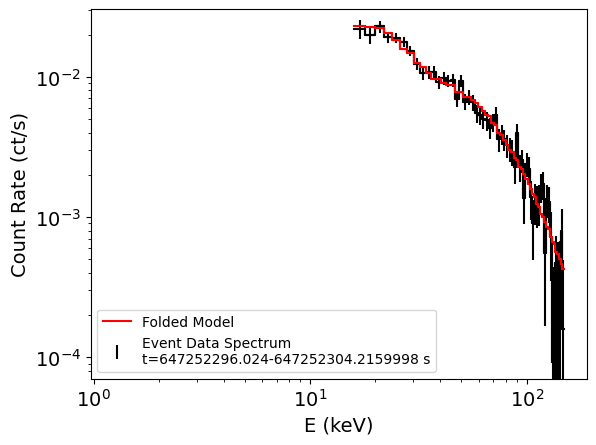

In [126]:
ba.fit_spectrum(spectrum_t90, generic_model="cflux*po",
                setPars={1:"15,-1", 2:"150,-1",3:-9, 4:"-1",5:".001,-1"},
                use_cstat=False, fit_iterations=10000)

In [127]:
params = spectrum_t90.spectral_model['parameters']
lg10_flux = params['lg10Flux']
flux = 10 ** lg10_flux['val']
flux_lo = 10 ** lg10_flux['lolim']
flux_hi = 10 ** lg10_flux['hilim']

print(f"Converted flux: best fit = {flux:.3e}, interval = ({flux_lo:.3e}, {flux_hi:.3e})")
# photon index
photon_index = params['PhoIndex']['val']
photon_index_lo = params['PhoIndex']['lolim']
photon_index_hi = params['PhoIndex']['hilim']

print(f"Photon index: best fit = {photon_index:.3f}, interval = ({photon_index_lo:.3f}, {photon_index_hi:.3f})")

Converted flux: best fit = 2.162e-07, interval = (2.088e-07, 2.238e-07)
Photon index: best fit = 1.609, interval = (1.546, 1.672)


## Time resolved spectra using Bayesian blocks

In [128]:
from batanalysis.batlib import concatenate_spectrum_data

spect_data = concatenate_spectrum_data(output_bayesian_spectra, ["flux", "phoindex"])

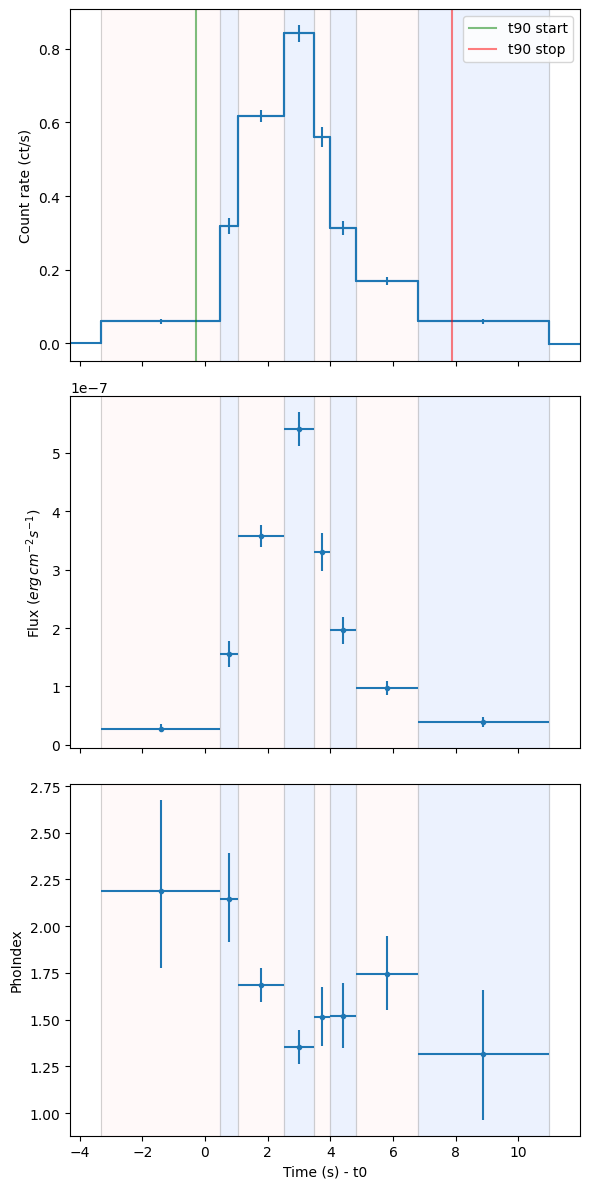

In [129]:
fig, axes = plt.subplots(3, sharex=True, figsize=(6, 12))

start_times = lc.tbins["TIME_START"]-t0*u.s
end_times = lc.tbins["TIME_STOP"]-t0*u.s
mid_times = lc.tbins["TIME_CENT"]-t0*u.s

bin_start_rel = (spect_data["TIME_START"] - t0 * u.s).to_value(u.s)
bin_stop_rel = (spect_data["TIME_STOP"] - t0 * u.s).to_value(u.s)
bin_colors = ["#ffe9e9", "#b7cefc"]
for idx, (start, stop) in enumerate(zip(bin_start_rel, bin_stop_rel)):
    color = bin_colors[idx % len(bin_colors)]
    for ax in axes:
        ax.axvspan(start, stop, color=color, alpha=0.25, zorder=0)

edges_rel = np.unique(np.concatenate([bin_start_rel, [bin_stop_rel[-1]]]))
for edge in edges_rel:
    for ax in axes:
        ax.axvline(edge, color="0.75", linewidth=0.8, alpha=0.7, zorder=1)

rate = lc.data['RATE']
rate_error = lc.data["ERROR"]
        
line = axes[0].plot(start_times, rate, ds='steps-post')
line_handle, = axes[0].plot(end_times, rate, ds='steps-pre', color=line[-1].get_color())

flux = spect_data['flux']
flux_lolim = spect_data['flux_lolim']
flux_hilim = spect_data['flux_hilim']

axes[0].errorbar(mid_times, rate, yerr=rate_error, ls='None', color=line[-1].get_color())
axes[0].set_ylabel('Count rate (ct/s)')

axes[0].axvline(lc.tdurs['T90']['TSTART'].value-t0, color='green', alpha=0.5, label="t90 start")
axes[0].axvline(lc.tdurs['T90']['TSTOP'].value-t0, color='red', alpha=0.5, label="t90 stop")

axes[0].legend()

spec_param = 'flux'

y = spect_data[spec_param]

# get the errors
lolim = spect_data[f"{spec_param}_lolim"]
hilim = spect_data[f"{spec_param}_hilim"]

yerr = np.array([lolim, hilim])
y_upperlim = spect_data[f"{spec_param}_upperlim"]

# find where we have upper limits and set the error to 1 since the nan error value isnt
# compatible with upperlimits
yerr[:, y_upperlim] = 0.2 * y[y_upperlim]

tbin_cent = 0.5 * (spect_data["TIME_START"] + spect_data["TIME_STOP"])
tbin_err = 0.5 * (spect_data["TIME_STOP"] - spect_data["TIME_START"])

axes[1].errorbar(
    tbin_cent-t0*u.s,
    y,
    xerr=tbin_err,
    yerr=yerr,
    uplims=y_upperlim,
    linestyle="None",
    marker="o",
    markersize=3,
    zorder=3,
)  # color="red"

axes[1].set_ylabel('Flux ($erg \, cm^{-2} s^{-1}$)')

spec_param = 'phoindex'

y = spect_data[spec_param]

# get the errors
lolim = spect_data[f"{spec_param}_lolim"]
hilim = spect_data[f"{spec_param}_hilim"]

yerr = np.array([lolim, hilim])
y_upperlim = spect_data[f"{spec_param}_upperlim"]

axes[2].errorbar(
    tbin_cent-t0*u.s,
    y,
    xerr=tbin_err,
    yerr=yerr,
    uplims=y_upperlim,
    linestyle="None",
    marker="o",
    markersize=3,
    zorder=3,
)  # color="red"

axes[2].set_ylabel('PhoIndex')
plt.xlim(min(spect_data["TIME_START"].value - t0) - 1, max(spect_data["TIME_STOP"].value - t0) + 1)
plt.xlabel('Time (s) - t0')
plt.tight_layout()